In [1]:
import numpy as np
from bitalg.visualizer.main import Visualizer
import random
import time
import functools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from math import sqrt
import mapbox_earcut as earcut

In [2]:
%matplotlib tk
from matplotlib.backend_bases import MouseButton
'''
Cała ta funkcja umożliwia zadawanie wierzchołków z myszki.
Po uruchomieniu kodu, włączy się okno, na którym należy klikać lewym przyciskiem myszy
w miejsca, w których chcemy, aby były nasze kolejne wierzchołki. Istnieje możliwość zapisania
figury, jeśli klikniemy w lewym dolnym rogu na ikonkę zapisu.
'''
polygon = []

fig, ax = plt.subplots()
ax.set_title('Polygon')
plt.xlim(0, 10)
plt.ylim(0, 10)

def on_click(event):
    if event.button is MouseButton.LEFT:
        x = event.xdata
        y = event.ydata
        polygon.append((x, y))
        ax.plot(*polygon[-1], marker='.', color='blue')
        plt.show()

plt.connect('button_press_event', on_click)
plt.show(block=True)
for x, y in polygon:
    print("x: ", x, " y: ", y)
%matplotlib inline

x:  3.9516129032258065  y:  4.821428571428572
x:  6.411290322580644  y:  2.62987012987013
x:  7.883064516129032  y:  7.635281385281386
x:  2.8830645161290325  y:  8.257575757575758
x:  1.2701612903225805  y:  4.117965367965368
x:  3.1048387096774195  y:  1.682900432900433
x:  8.044354838709676  y:  2.4945887445887447


In [3]:
def generate_points(n, max_x, max_y):
    points = []
    for _ in range(n):
        x = random.uniform(0, max_x)
        y = random.uniform(0, max_y)
        points.append((x, y))
    
    return points

In [4]:
class Point:
        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.neighbors: set[Point] = set()
            self.faces: set[Face] = set()
            
        def position(self):
            return self.x, self.y
        
        def add_neighbors(self, v):
            self.neighbors.add(v)

        def assign_face(self, face):
            self.faces.add(face)
            
        def __str__(self):
            return f"Point: ({self.x}, {self.y})"
        
        def __repr__(self):
            return f"Point: ({self.x}, {self.y})"
        
        def __add__(self, vector):
            return Point(self.x + vector[0], self.y + vector[1])
            
        def __eq__(self, other):
            return self.x == other.x and self.y == other.y
        
        def __hash__(self):
            return hash((self.x, self.y))

class Face:
    def __init__(self, coordinates):
        self.coordinates: set[Point] = coordinates
        
    def __repr__(self):
        return f"Face: {self.coordinates}"
    
    def __str__(self):
        return f"Face: {self.coordinates}"
    
    def triangle(self):
        return len(self.coordinates) == 3
    
    def contains(self, point):
        if self.triangle():
            return self.inside_triangle(point)
        
        raise Exception("Face is not a triangle")

    def inside_triangle(self, point):
        coords = list(self.coordinates)
                
        def sign(p1, p2, p3):
            return (p2.x - p1.x) * (p3.y - p1.y) - (p3.x - p1.x) * (p2.y - p1.y)
        
        b1 = sign(point, coords[0], coords[1])
        b2 = sign(point, coords[1], coords[2])
        b3 = sign(point, coords[2], coords[0])
                
        return b1 >= 0 and b2 >= 0 and b3 >= 0 or b1 <= 0 and b2 <= 0 and b3 <= 0
    
    def __eq__(self, other):
            return self.coordinates == other.coordinates

    def __hash__(self):
            return hash(tuple(self.coordinates))
    

class Node:
    def __init__(self, face: Face):
        self.face = face
        self.children = []
        
    def __repr__(self):
        return f"Node: {self.face}"


In [5]:
def determinant(a, b, c):
    return (b.x - a.x) * (c.y - a.y) - (c.x - a.x) * (b.y - a.y)

def distance(a, b):
    return np.sqrt((a.x - b.x) ** 2 + (a.y - b.y) ** 2)

In [6]:
def lower_left(polygon: list[Point]):
    minpoint = Point(float('inf'), float('inf'))
    for point in polygon:
        if point.y < minpoint.y:
            minpoint = point
        elif point.y == minpoint.y and point.x < minpoint.x:
            minpoint = point
    return minpoint

def graham_algorithm(polygon: list[Point]):
    '''
    Funkcja buduje otoczkę wypukłą dla podanego
    zbioru punktów Q algorymem Grahama
    :parm Q: zbiór punktów
    :return: tablica punktów w postaci krotek współrzędnych
    '''
    def orient(a, b, c):
        d = determinant(a, b, c)
        if d > 0:
            return -1
        elif d < 0:
            return 1
        else:
            return 0
        
    def comp_key(a, b):
        if orient(first_point, a, b) == 0:
            if distance(first_point, b) >= distance(first_point, a):
                return -1
            else:
                return 1
        return orient(first_point, a, b)
        
    if len(polygon)<3:
        return polygon
    
    first_point = lower_left(polygon)
    sorted_points = sorted(polygon, key=functools.cmp_to_key(comp_key))
    
    S = [sorted_points[0], sorted_points[1], sorted_points[2]]

    m = len(sorted_points)
    for i in range(3, m):
        while len(S) > 1 and orient(S[-2], S[-1], sorted_points[i]) != -1:
            S.pop()
        S.append(sorted_points[i])
        
    return S

In [7]:
def generate_outer_triangle(points: list[Point]):
    """
    Funkcja generuje trójkąt otaczający zbiór punktów.
    :param points: tablica krotek punktów na płaszczyźnie euklidesowej
    :return: tablica krotek punktów tworzących trójkąt otaczający zbiór punktów
    """
    
    min_x = min(points, key=lambda x: x.x).x
    max_x = max(points, key=lambda x: x.x).x
    min_y = min(points, key=lambda x: x.y).y
    max_y = max(points, key=lambda x: x.y).y
    
    lower_left_corner = Point(min_x, min_y)
    upper_right_corner = Point(max_x, max_y)
    
    move_away = distance(lower_left_corner, upper_right_corner) / 10
    
    # Equilateral triangle
    triangle_left_point = (Point(lower_left_corner.x, lower_left_corner.y)
         + ((lower_left_corner.y - upper_right_corner.y) / sqrt(3) - move_away,
         -move_away))
    
    triangle_right_point = (Point(upper_right_corner.x, lower_left_corner.y)
         + ((upper_right_corner.y - lower_left_corner.y) / sqrt(3) + move_away, -move_away))
    
    triangle_top_point = (Point(lower_left_corner.x, upper_right_corner.y)
        + ((upper_right_corner.x - lower_left_corner.x) / 2, (upper_right_corner.x - lower_left_corner.x) / 2 * sqrt(3) + move_away))
  
    return [triangle_left_point, triangle_right_point, triangle_top_point]

def triangulate_points(points: list[Point]):
    
    point_tuples = [point.position() for point in points]
    triangles = Delaunay(np.array(point_tuples)).simplices

    faces = set()
    for i in range(len(triangles)):
        a = points[triangles[i][0]]
        b = points[triangles[i][1]]
        c = points[triangles[i][2]]
        triangle = {a, b, c}
        new_triangle = Face(triangle)
        faces.add(new_triangle)
        
        a.assign_face(new_triangle)
        b.assign_face(new_triangle)
        c.assign_face(new_triangle)

        a.add_neighbors(b)
        a.add_neighbors(c)
        b.add_neighbors(a)
        b.add_neighbors(c)
        c.add_neighbors(a)
        c.add_neighbors(b)
    return faces  

def connect_outer_triangle(convex_hull: list[Point], outer_triangle: list[Point]):
    
    points = convex_hull + outer_triangle
    to_check = set(convex_hull)
    point_tuples = [point.position() for point in points]
    triangles = Delaunay(np.array(point_tuples)).simplices

    faces = set()
    for i in range(len(triangles)):
        a = points[triangles[i][0]]
        b = points[triangles[i][1]]
        c = points[triangles[i][2]]
        triangle = {a, b, c}
        if not triangle.issubset(to_check):
            new_triangle = Face(set(triangle))
            faces.add(new_triangle)
            
            a.assign_face(new_triangle)
            b.assign_face(new_triangle)
            c.assign_face(new_triangle)

            a.add_neighbors(b)
            a.add_neighbors(c)
            b.add_neighbors(a)
            b.add_neighbors(c)
            c.add_neighbors(a)
            c.add_neighbors(b)

    return faces  

In [8]:
def prepare_polygon(points: set[Point], point_to_remove: Point):
    
    alpha_values = []
    for point in points:
        xi = point.x - point_to_remove.x
        yi = point.y - point_to_remove.y
        di = abs(xi) + abs(yi)
        
        if xi >= 0 and yi >= 0:
            alpha_values.append(yi / di)
            
        elif xi < 0 <= yi:
            alpha_values.append(2 - yi / di)
            
        elif xi < 0 and yi < 0:
            alpha_values.append(2 + abs(yi) / di)
            
        elif xi >= 0 > yi:
            alpha_values.append(4 - abs(yi) / di)
            
    points = sorted(zip(alpha_values, points), key=lambda x: x[0])
    return [point[1] for point in points]

def ear_triangulation(points: list[Point]):
    point_tuples = [point.position() for point in points]
    verts = np.array(point_tuples).reshape(-1, 2)
    rings = np.array([len(verts)])

    result = earcut.triangulate_float64(verts, rings)
    
    faces = set()
    for i in range(0, len(result), 3):
        a = points[result[i]]
        b = points[result[i+1]]
        c = points[result[i+2]]
        triangle = {a, b, c}

        new_triangle = Face(triangle)
        faces.add(new_triangle)
        
        a.assign_face(new_triangle)
        b.assign_face(new_triangle)
        c.assign_face(new_triangle)

        a.add_neighbors(b)
        a.add_neighbors(c)
        b.add_neighbors(a)
        b.add_neighbors(c)
        c.add_neighbors(a)
        c.add_neighbors(b)

    return faces  

def triangulate_region(face: Face, point_to_remove: Point):  
    face_points = prepare_polygon(face.coordinates, point_to_remove)

    if not face.triangle():
        new_faces = ear_triangulation(face_points)
        return new_faces
    else:
        a, b, c = face_points[0], face_points[1], face_points[2]
        
        a.assign_face(face)
        b.assign_face(face)
        c.assign_face(face)

        a.add_neighbors(b)
        a.add_neighbors(c)
        b.add_neighbors(a)
        b.add_neighbors(c)
        c.add_neighbors(a)
        c.add_neighbors(b)
        
        return {face}


In [9]:
def remove_independent_set(points: set[Point], faces: set[Face], outer_triangle: list[Point]):

    avoid = set(outer_triangle)
    delete = set()
    for point in points:
        if point not in avoid and len(point.neighbors) <= 8:
            delete.add(point)
            avoid.update(point.neighbors)

    for point in delete:        
        new_polygon = point.neighbors
        faces.difference_update(point.faces)
        points.remove(point)

        for pt in point.neighbors:
            pt.neighbors.remove(point)
            pt.faces.difference_update(point.faces)
            
        face = Face(new_polygon)
        new_triangles = triangulate_region(face, point)
        for new_triangle in new_triangles:
            faces.add(new_triangle)
    
    
def preprocess_regions(points: list[Point], vis):
    
    faces = set()

    faces_inside = triangulate_points(points)
    faces.update(faces_inside)
    convex_hull = graham_algorithm(points)

    prev_nodes = []
    for face in faces:
        node = Node(face)
        prev_nodes.append(node)

    if len(convex_hull) < 3:
        raise Exception("Niepoprawne wejście")

    if len(convex_hull) > 3:
        outer_triangle = generate_outer_triangle(points)
        
        pocket_faces = connect_outer_triangle(convex_hull, outer_triangle)
        points += outer_triangle
        faces.update(pocket_faces)
    else:
        outer_triangle = convex_hull
    
    for point in outer_triangle:
        vis.add_point(point.position(), color='blue')

    #     VIS     #
    for face in faces:
        points_tuples = list(face.coordinates)
        for i in range(len(points_tuples)):
            vis.add_line_segment((points_tuples[i].position(), points_tuples[(i + 1) % len(points_tuples)].position()), color="blue")    
    vis.show()
    vis.clear()
    ##############
    points_set = set()
    for point in points:
        points_set.add(point)

    while len(faces) > 1:
        remove_independent_set(points_set, faces, outer_triangle)
        
        curr_nodes = []
        for face in faces:
            node = Node(face)
            curr_nodes.append(node)
            
            for prev_node in prev_nodes:
                prev_face_coords = list(prev_node.face.coordinates)
                if face.contains(prev_face_coords[0]) or face.contains(prev_face_coords[1]) or face.contains(prev_face_coords[2]):
                    node.children.append(prev_node)
    
        prev_nodes = curr_nodes
        
        
    root = prev_nodes[0]
    return root

def locate_point(points: list[Point], searched_point: list[Point], vis):

    root = preprocess_regions(points, vis)
    
    if not root.face.contains(searched_point):
        return None
    
    curr = root
    children = curr.children
    while children:
        for node in children:
            if node.face.contains(searched_point):
                curr = node
                break

        children = curr.children
    
    
    return curr.face
    
def kirkpatrick(points: list[tuple], searched_point: tuple, vis):
    points = [Point(*point) for point in points]
    searched_point = Point(searched_point[0], searched_point[1])
    return locate_point(points, searched_point, vis)


def show_result(points: list[tuple], final_face: Face, searched_point: tuple):
    
    vis = Visualizer()
    
    for point in points:
        vis.add_point((point[0], point[1]), color="blue")
        
    for point in final_face.coordinates:
        vis.add_point((point.x, point.y), color="red")
        
    points_tuples = list(final_face.coordinates)
    
    vis.add_point(searched_point, color="green")
    
    for i in range(len(points_tuples)):
        vis.add_line_segment(((points_tuples[i].x, points_tuples[i].y), (points_tuples[(i + 1) % len(points_tuples)].x, points_tuples[(i + 1) % len(points_tuples)].y)), color="red")
        
    vis.show()

Face: {Point: (10, 15), Point: (20, 12), Point: (14, 20)}


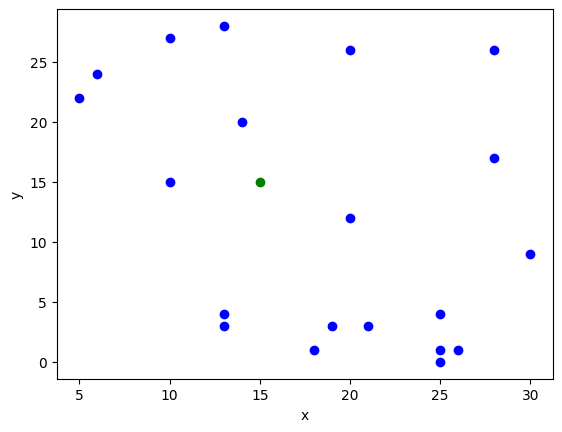

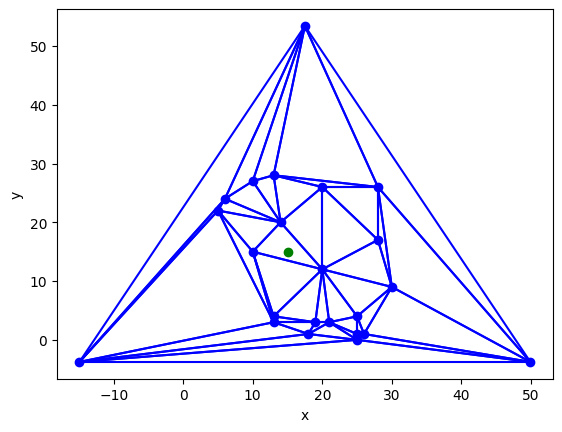

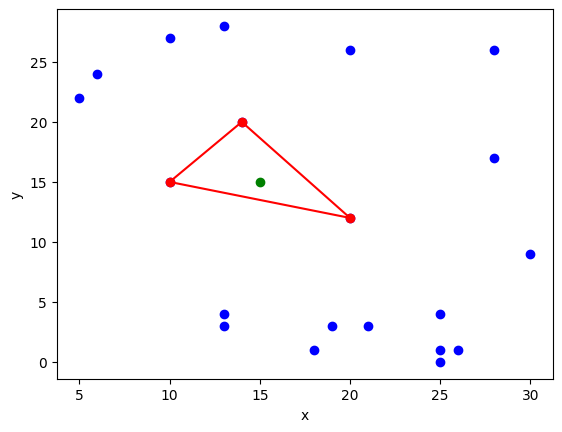

In [10]:
points = [(13, 3), (10, 27), (28, 26), (14, 20), (20, 12), (18, 1), (6, 24), (25, 0), (13, 4), (21, 3), (28, 17), (25, 1), (25, 4), (30, 9), (20, 26), (10, 15), (19, 3), (13, 28), (5, 22), (26, 1)]
searched_point = (15, 15)
vis = Visualizer()
vis.add_point(points, color='blue')
vis.add_point(searched_point, color='green')
vis.show()
result = kirkpatrick(points, searched_point, vis)
print(result)
show_result(points, result, searched_point)

Face: {Point: (2.9637096774193545, 5.8495670995671), Point: (2.8629032258064515, 5.30844155844156), Point: (6.55241935483871, 4.686147186147187)}


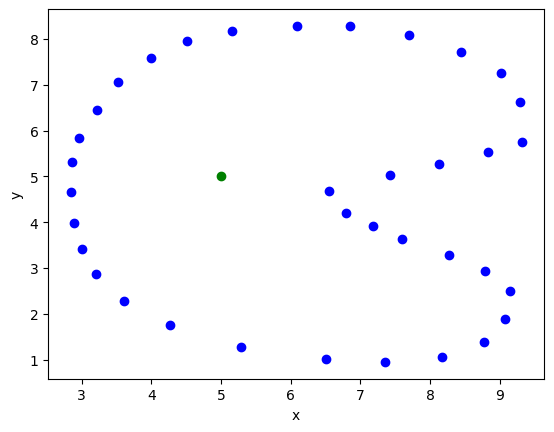

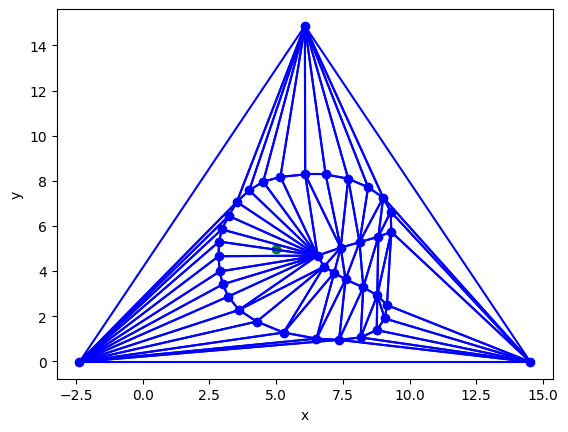

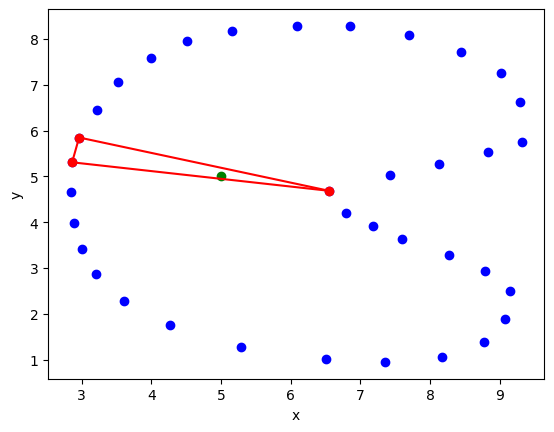

In [11]:
points = [(6.55241935483871, 4.686147186147187), (7.419354838709676, 5.037878787878789), (8.125, 5.2813852813852815), (8.830645161290322, 5.524891774891776), (9.314516129032258, 5.741341991341992), (9.294354838709676, 6.634199134199134), (9.012096774193548, 7.256493506493507), (8.44758064516129, 7.716450216450218), (7.701612903225806, 8.095238095238097), (6.854838709677418, 8.284632034632036), (6.088709677419354, 8.284632034632036), (5.161290322580646, 8.176406926406928), (4.516129032258064, 7.95995670995671), (3.9919354838709675, 7.5811688311688314), (3.5282258064516125, 7.067099567099568), (3.2258064516129035, 6.4448051948051965), (2.9637096774193545, 5.8495670995671), (2.8629032258064515, 5.30844155844156), (2.8427419354838706, 4.65909090909091), (2.8830645161290325, 3.9826839826839833), (3.0040322580645165, 3.414502164502165), (3.2056451612903225, 2.873376623376624), (3.6088709677419355, 2.2781385281385287), (4.274193548387096, 1.7640692640692648), (5.282258064516128, 1.2770562770562774), (6.512096774193548, 1.006493506493507), (7.358870967741934, 0.952380952380953), (8.16532258064516, 1.060606060606061), (8.77016129032258, 1.385281385281386), (9.07258064516129, 1.8993506493506498), (9.153225806451612, 2.494588744588745), (8.79032258064516, 2.927489177489178), (8.266129032258064, 3.2792207792207804), (7.600806451612902, 3.630952380952382), (7.17741935483871, 3.9285714285714293), (6.794354838709676, 4.1991341991342)]
searched_point = (5, 5)
vis = Visualizer()
vis.add_point(points, color='blue')
vis.add_point(searched_point, color='green')
vis.show()
result = kirkpatrick(points, searched_point, vis)
print(result)
show_result(points, result, searched_point)

Face: {Point: (4.556451612903226, 4.875541125541126), Point: (4.778225806451612, 8.528138528138529), Point: (6.028225806451612, 3.576839826839828)}


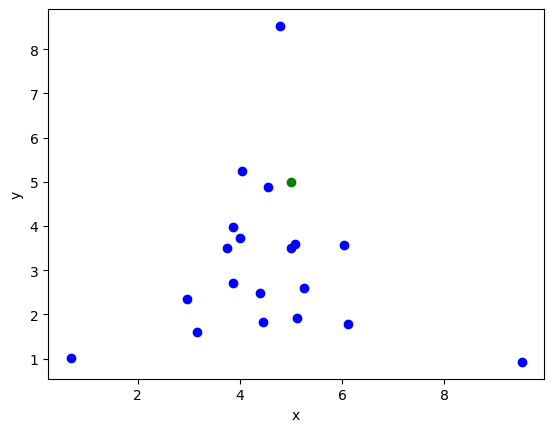

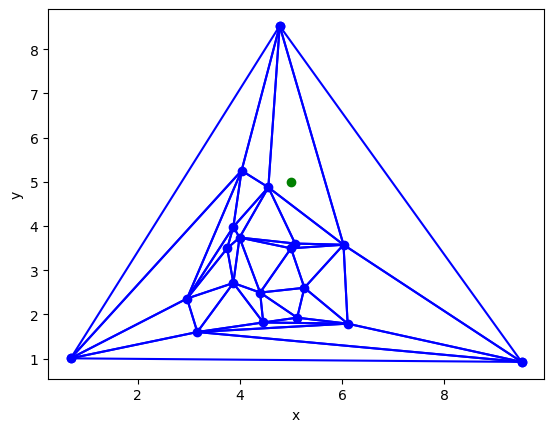

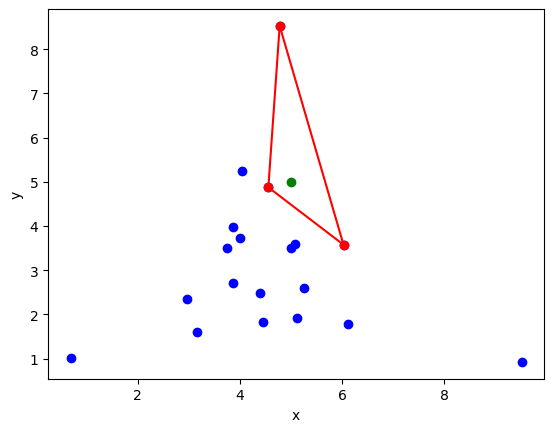

In [12]:
points = [(4.778225806451612, 8.528138528138529), (0.685483870967742, 1.006493506493507), (9.516129032258064, 0.925324675324676), (4.556451612903226, 4.875541125541126), (3.8709677419354835, 3.9826839826839833), (3.7499999999999996, 3.4956709956709964), (3.8709677419354835, 2.711038961038962), (5.120967741935484, 1.9264069264069268), (6.108870967741936, 1.7911255411255418), (6.028225806451612, 3.576839826839828), (5.080645161290322, 3.6038961038961044), (4.39516129032258, 2.494588744588745), (3.1653225806451615, 1.6017316017316023), (2.9637096774193545, 2.35930735930736), (3.9919354838709675, 3.73917748917749), (4.032258064516128, 5.254329004329005), (5.0, 3.4956709956709964), (5.262096774193548, 2.602813852813853), (4.455645161290322, 1.8181818181818188)]
searched_point = (5, 5)
vis = Visualizer()
vis.add_point(points, color='blue')
vis.add_point(searched_point, color='green')
vis.show()
result = kirkpatrick(points, searched_point, vis)
print(result)
show_result(points, result, searched_point)

Face: {Point: (3.8911290322580645, 5.146103896103897), Point: (5.987903225806452, 4.740259740259741), Point: (6.028225806451612, 7.527056277056278)}


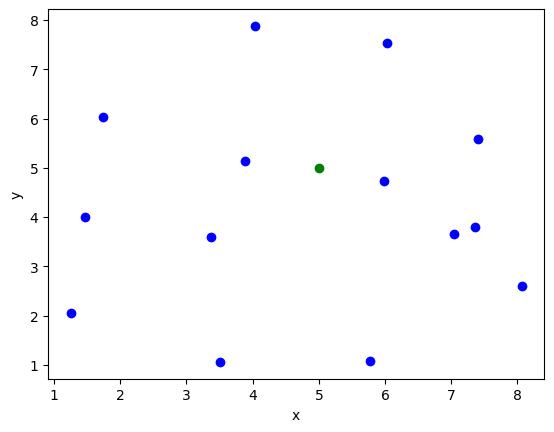

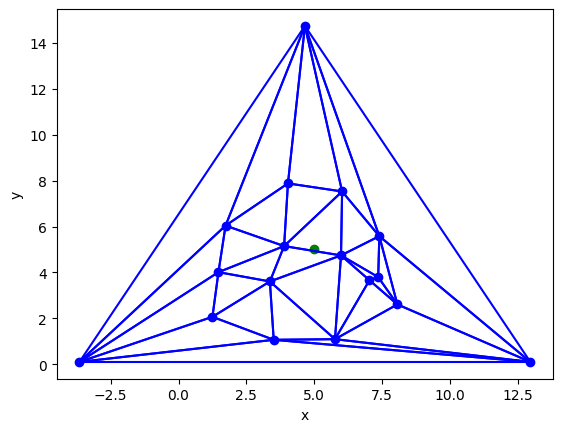

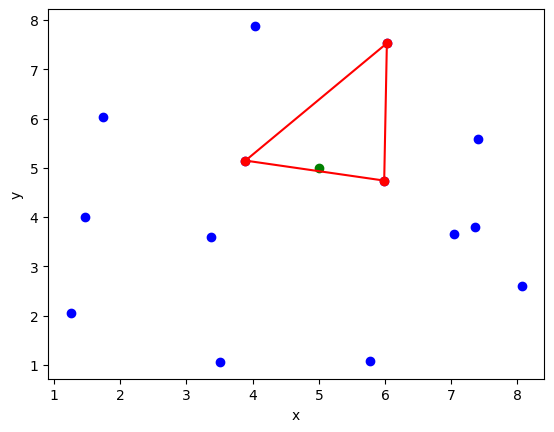

In [13]:
points = [(4.032258064516128, 7.878787878787879), (1.7338709677419355, 6.038961038961039), (1.471774193548387, 4.00974025974026), (1.25, 2.061688311688312), (3.5080645161290325, 1.0606060606060606), (5.766129032258064, 1.0876623376623376), (8.064516129032258, 2.6028138528138527), (7.399193548387096, 5.57900432900433), (6.028225806451612, 7.527056277056278), (7.036290322580644, 3.658008658008658), (3.8911290322580645, 5.146103896103897), (3.3669354838709675, 3.603896103896104), (7.358870967741934, 3.7932900432900434), (5.987903225806452, 4.740259740259741)]
searched_point = (5, 5)
vis = Visualizer()
vis.add_point(points, color='blue')
vis.add_point(searched_point, color='green')
vis.show()
result = kirkpatrick(points, searched_point, vis)
print(result)
show_result(points, result, searched_point)

Face: {Point: (7.883064516129032, 7.635281385281386), Point: (6.411290322580644, 2.62987012987013), Point: (3.9516129032258065, 4.821428571428572)}


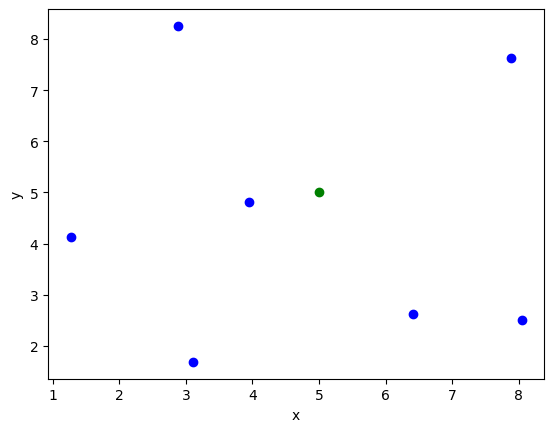

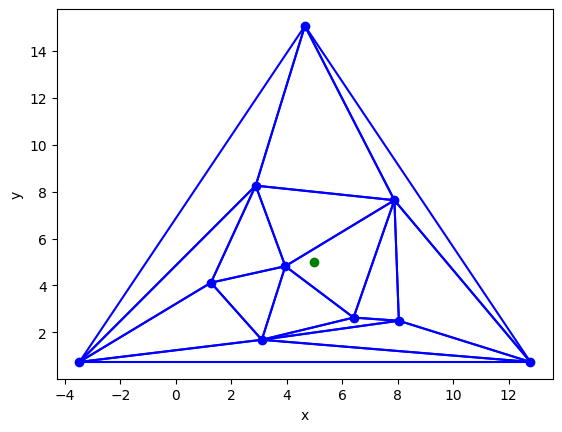

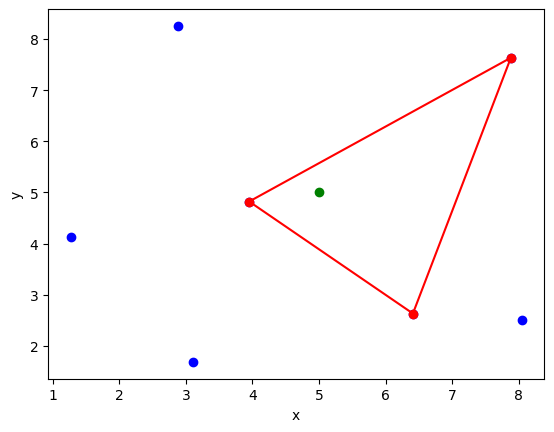

In [14]:
if __name__ == "__main__":
    points = polygon
    searched_point = (5, 5)

    #test 1
    #points = [(13, 3), (10, 27), (28, 26), (14, 20), (20, 12), (18, 1), (6, 24), (25, 0), (13, 4), (21, 3), (28, 17), (25, 1), (25, 4), (30, 9), (20, 26), (10, 15), (19, 3), (13, 28), (5, 22), (26, 1)]
    #searched_point = (15, 15)
    #odpowiedz: Face: {Point: (10, 15), Point: (20, 12), Point: (14, 20)}
    
    #test 2
    #points = [(6.55241935483871, 4.686147186147187), (7.419354838709676, 5.037878787878789), (8.125, 5.2813852813852815), (8.830645161290322, 5.524891774891776), (9.314516129032258, 5.741341991341992), (9.294354838709676, 6.634199134199134), (9.012096774193548, 7.256493506493507), (8.44758064516129, 7.716450216450218), (7.701612903225806, 8.095238095238097), (6.854838709677418, 8.284632034632036), (6.088709677419354, 8.284632034632036), (5.161290322580646, 8.176406926406928), (4.516129032258064, 7.95995670995671), (3.9919354838709675, 7.5811688311688314), (3.5282258064516125, 7.067099567099568), (3.2258064516129035, 6.4448051948051965), (2.9637096774193545, 5.8495670995671), (2.8629032258064515, 5.30844155844156), (2.8427419354838706, 4.65909090909091), (2.8830645161290325, 3.9826839826839833), (3.0040322580645165, 3.414502164502165), (3.2056451612903225, 2.873376623376624), (3.6088709677419355, 2.2781385281385287), (4.274193548387096, 1.7640692640692648), (5.282258064516128, 1.2770562770562774), (6.512096774193548, 1.006493506493507), (7.358870967741934, 0.952380952380953), (8.16532258064516, 1.060606060606061), (8.77016129032258, 1.385281385281386), (9.07258064516129, 1.8993506493506498), (9.153225806451612, 2.494588744588745), (8.79032258064516, 2.927489177489178), (8.266129032258064, 3.2792207792207804), (7.600806451612902, 3.630952380952382), (7.17741935483871, 3.9285714285714293), (6.794354838709676, 4.1991341991342)]
    #searched_point = (5, 5)
    #odpowiedz: Face: {Point: (2.9637096774193545, 5.8495670995671), Point: (2.8629032258064515, 5.30844155844156), Point: (6.55241935483871, 4.686147186147187)}
    
    #test 3
    #points = [(4.778225806451612, 8.528138528138529), (0.685483870967742, 1.006493506493507), (9.516129032258064, 0.925324675324676), (4.556451612903226, 4.875541125541126), (3.8709677419354835, 3.9826839826839833), (3.7499999999999996, 3.4956709956709964), (3.8709677419354835, 2.711038961038962), (5.120967741935484, 1.9264069264069268), (6.108870967741936, 1.7911255411255418), (6.028225806451612, 3.576839826839828), (5.080645161290322, 3.6038961038961044), (4.39516129032258, 2.494588744588745), (3.1653225806451615, 1.6017316017316023), (2.9637096774193545, 2.35930735930736), (3.9919354838709675, 3.73917748917749), (4.032258064516128, 5.254329004329005), (5.0, 3.4956709956709964), (5.262096774193548, 2.602813852813853), (4.455645161290322, 1.8181818181818188)]
    #searched_point = (5, 5)
    #odpowiedz: Face: {Point: (4.556451612903226, 4.875541125541126), Point: (4.778225806451612, 8.528138528138529), Point: (6.028225806451612, 3.576839826839828)}

    #test 4
    #points = [(4.032258064516128, 7.878787878787879), (1.7338709677419355, 6.038961038961039), (1.471774193548387, 4.00974025974026), (1.25, 2.061688311688312), (3.5080645161290325, 1.0606060606060606), (5.766129032258064, 1.0876623376623376), (8.064516129032258, 2.6028138528138527), (7.399193548387096, 5.57900432900433), (6.028225806451612, 7.527056277056278), (7.036290322580644, 3.658008658008658), (3.8911290322580645, 5.146103896103897), (3.3669354838709675, 3.603896103896104), (7.358870967741934, 3.7932900432900434), (5.987903225806452, 4.740259740259741)]
    #searched_point = (5, 5)
    #odpowiedz: Face: {Point: (3.8911290322580645, 5.146103896103897), Point: (5.987903225806452, 4.740259740259741), Point: (6.028225806451612, 7.527056277056278)}
    
    #print(points)

    #     VIS     #
    vis = Visualizer()
    vis.add_point(points, color='blue')
    vis.add_point(searched_point, color='green')
    vis.show()
    ##############
    
    result = kirkpatrick(points, searched_point, vis)
    print(result)
    show_result(points, result, searched_point)